In [1]:
import sys
import os 
import fnmatch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import axes 
from scipy.optimize import curve_fit 
from scipy.stats import norm
import numpy as np
current_directory = os.getcwd()
data_directory = current_directory+"\\extracted_data\\"
import pandas as pd
import uproot
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
sys.path.insert(1, r'C:\Users\Pascal\Desktop\TP4a\git_final_final\ecal_reco\utils')
sys.path.insert(1, r'C:\Users\Pascal\Desktop\TP4a\git_final_final\ecal_reco\tracking')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
from parameters import *
from tqdm import tqdm
from track_reconstruction import plot_hits
from physics import dist_line_rect
import pickle
from IPython import display
from time_correction import *
# from find_muon_decay import find_muon_decay
import random
from statistics import mean 

In [34]:
# Create the tracks form the raw datas and the indices events selected previously with data_creation_time
import copy

run ='run_000011'
data_storage = current_directory+"\\extracted_data\\"
raw_data_directory = "C:\\Users\\Pascal\\Desktop\\TP4a\\data\\"
df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\") #warning, the df_hits is a list of events, not of hits !
good_candidates = np.loadtxt(data_storage+"events_indices_"+run+".txt") #load the indices of the events selected as good candidates

#Now we will extract the hits of each events and create tracks for each of them

%matplotlib inline
ttracks = []
uncorrected_tracks = []
fiber_corrected_tracks = []
for i in range(len(good_candidates)) :
    event = df_hits.loc[good_candidates[i]] #select the event i among the good candidates
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,j) for j in range(event['n_hits' ])] #create an array "hits" with the hits of the event i (iteration on j inside the event)
    # print (hits)    
    tempTrack = Track3D(hits) #creation of a track with the hits of the event i
    uncorrected_tracks.append(copy.deepcopy(tempTrack))
    fiber_corrected_tracks.append(copy.deepcopy(time_correction_fiber(tempTrack)))
    ttracks.append(time_correction_electronics(tempTrack)) # add the track i to the tracks array witg geomertical time correction
    # print(track)

C:\Users\Pascal\Desktop\TP4a\data\run_000011\data_0000.root
selected 74.91% of all events


In [37]:
with open('uncorrected_tracks_run11.pkl','wb') as file :
    pickle.dump(uncorrected_tracks, file)
with open('fiber_corrected_tracks_run11.pkl','wb') as file :
    pickle.dump(fiber_corrected_tracks, file)
with open('tracks_run11.pkl','wb') as file :
    pickle.dump(ttracks, file)
with open('muXF.pkl','wb') as file :
    pickle.dump(muXF, file)
with open('muYF.pkl','wb') as file :
    pickle.dump(muYF, file)

In [36]:
countX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muXF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

countY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muYF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

iterations = 5
ConvergTrackingX = []
ConvergTrackingY = []

for it in range(iterations):
    for i in range(24):
        for j in range(8):
            time = []
            for t in ttracks:
                for hx in t.x.hits:
                    if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
                        countX[i][j] += 1
                        tbar = hx.timestamp
                        for hxp in t.x.hits:
                            if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                                time.append(hxp.timestamp-tbar-muXF[i][j]-muXF[hxp.coord[0]-1][hxp.coord[1]-1])
            muX[i][j], sigmaX[i][j] = norm.fit(time)
            time = []
            for t in ttracks:
                for hy in t.y.hits:
                    if hy.coord[0]-1 == i and hy.coord[1]-1 == j: # if its the ith jth bar in x
                        countY[i][j] += 1
                        tbar = hy.timestamp
                        for hyp in t.y.hits:
                            if(not(hyp.coord[0]-1 == i and hyp.coord[1]-1 == j and not(hyp.is_sidex))):
                                time.append(hyp.timestamp-tbar-muYF[i][j]-muYF[hyp.coord[0]-1][hyp.coord[1]-1])
            muY[i][j], sigmaY[i][j] = norm.fit(time)
    ConvergTrackingX.append(np.max(np.max(np.abs(muX))))
    ConvergTrackingY.append(np.max(np.max(np.abs(muY))))
    muXF = muXF + muX
    muYF = muYF + muY




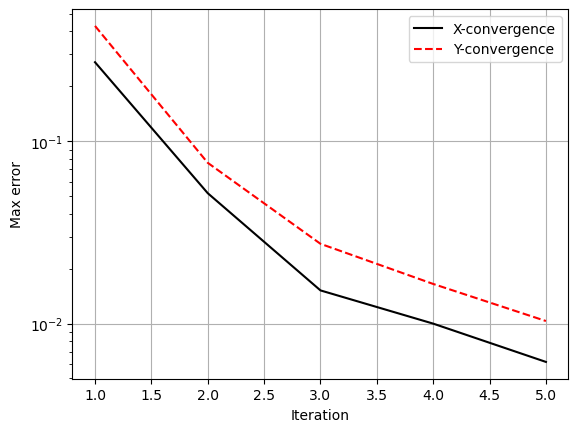

In [38]:
plt.figure()
plt.semilogy(range(1, iterations + 1),ConvergTrackingX,'k')
plt.semilogy(range(1, iterations + 1),ConvergTrackingY,'r--')
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Max error")
plt.legend(["X-convergence","Y-convergence"])

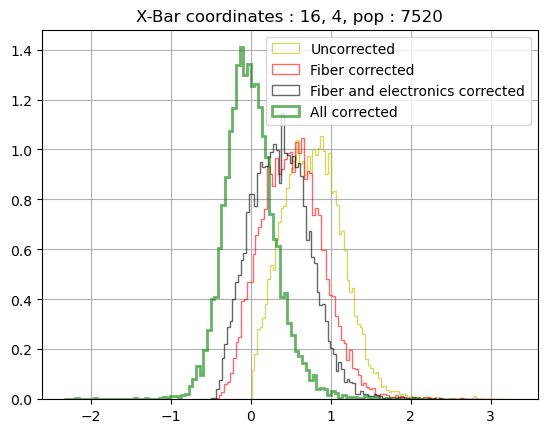

In [5]:
i = random.randint(0,23)
j = random.randint(0,7)

time = []
for t in uncorrected_tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp)

plt.figure()
plt.hist(time, bins=100, density=True, alpha=0.6, color='y', histtype='step')

time = []
for t in fiber_corrected_tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp)

plt.hist(time, bins=100, density=True, alpha=0.6, color='r', histtype='step')
plt.title("Fiber corrected")

time = []
for t in tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp)

plt.hist(time, bins=100, density=True, alpha=0.6, color='k', histtype='step')
plt.title("All corrected")

time = []
for t in tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp-tbar-muXF[i][j]-muXF[hxp.coord[0]-1][hxp.coord[1]-1])

plt.hist(time, bins=100, density=True, alpha=0.6, color='g', histtype='step', linewidth = 2)
plt.title("All corrected")


plt.legend(["Uncorrected","Fiber corrected","Fiber and electronics corrected", "All corrected"])
plt.title("X-Bar coordinates : " + str(i+1) + ", " + str(j+1) + ", pop : " + str(countX[i][j]))
plt.grid()


Worse


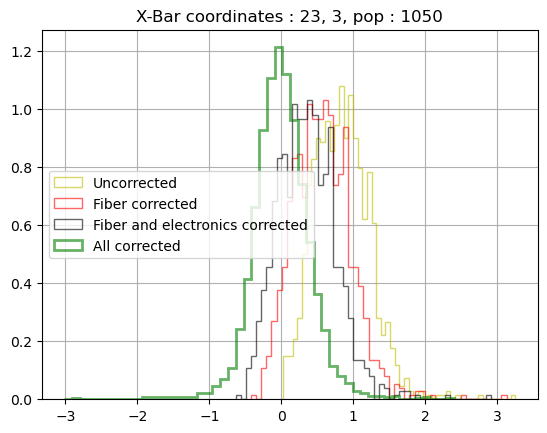

In [72]:
i = random.randint(0,23)
j = random.randint(0,7)
beans = 50 #bins lol
time = []
for t in uncorrected_tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            time.append(tbar)
muuncorr, sigmauncorr = norm.fit(time)
plt.figure()
plt.hist(time, bins=beans, density=True, alpha=0.6, color='y', histtype='step')

time = []
for t in fiber_corrected_tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            time.append(tbar)

plt.hist(time, bins=beans, density=True, alpha=0.6, color='r', histtype='step')
plt.title("Fiber corrected")
mufiber, sigmafiber = norm.fit(time)
time = []
for t in ttracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            time.append(tbar)

plt.hist(time, bins=beans, density=True, alpha=0.6, color='k', histtype='step')
plt.title("All corrected")

time = []
for t in ttracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp-tbar-muXF[i][j]-muXF[hxp.coord[0]-1][hxp.coord[1]-1])

plt.hist(time, bins=beans, density=True, alpha=0.6, color='g', histtype='step', linewidth = 2)
plt.title("All corrected")


plt.legend(["Uncorrected","Fiber corrected","Fiber and electronics corrected", "All corrected"])
plt.title("X-Bar coordinates : " + str(i+1) + ", " + str(j+1) + ", pop : " + str(int(countX[i][j]/iterations)))
plt.grid()
if(sigmauncorr/sigmafiber<1):
    print("Worse")
else:
    print("Better")


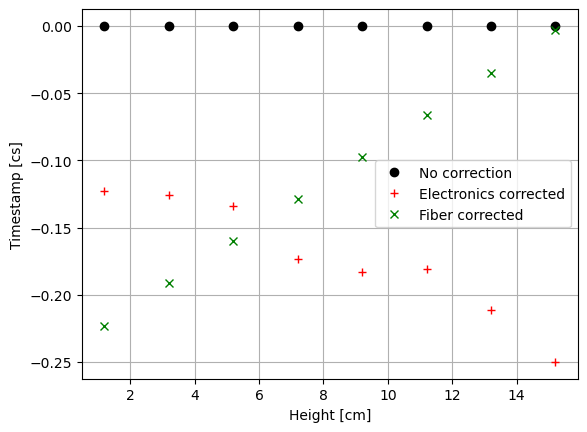

In [21]:
from track import Track
from time_correction import*
Hx=[]
Hy=[]
for number_hits in range(8):
    Hx.append(Hit([number_hits+1,8-number_hits],1,0,1000,0.0))#(coord, is_sidex, timestamp, timestamp_event, value)
    Hy.append(Hit([24-number_hits,8-number_hits],0,0,1000,0.0))
Tx = Track(Hx)
Ty = Track(Hy)
T = Track3D(Tx,Ty)
T.show()

T_fiber_corrected = copy.deepcopy(T)
T_electronic_corrected = copy.deepcopy(T)
time_correction_fiber(T_fiber_corrected)
time_correction_electronics(T_electronic_corrected)

# recover the corrected stamps
heights = []
s_nocorr = []
s_ecorr = []
s_fibcorr = []

for h in T.y.hits:#+ T.y.hits:
    heights.append(h.get_pos()[1])
    s_nocorr.append(h.timestamp)
for h in T_fiber_corrected.y.hits:# + T_fiber_corrected.y.hits:
    s_fibcorr.append(h.timestamp)
for h in T_electronic_corrected.y.hits:# + T_electronic_corrected.y.hits:
    s_ecorr.append(h.timestamp)

plt.figure()
plt.plot(heights,s_nocorr,'ko')
plt.plot(heights,s_ecorr, 'r+')
plt.plot(heights,s_fibcorr,'gx')
plt.grid()
plt.xlabel("Height [cm]")
plt.ylabel("Timestamp [cs]")
plt.legend(["No correction","Electronics corrected","Fiber corrected"])


In [19]:
print(np.max(np.max(np.abs(muXF))))
print(np.max(np.max(np.abs(muYF))))

0.29910389485146166
0.4401072291234432


In [33]:
with open('tracks_run11.pkl', 'rb') as file:  # Open the file in read-binary mode ('rb')
    ttracks = pickle.load(file)
print(ttracks)

<function tracks at 0x0000019C3DD2A160>


0.1748154
0.1198526473362094


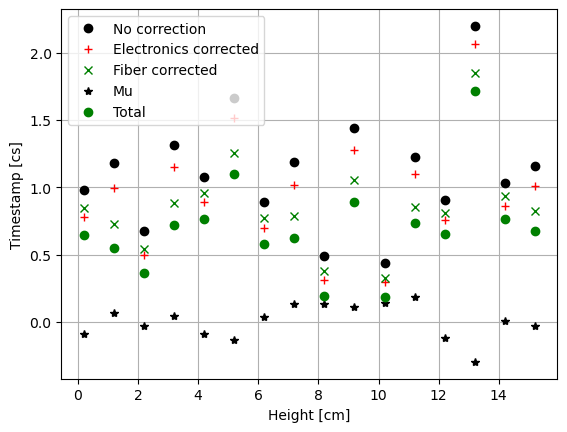

In [119]:
from track import Track
from time_correction import*

selected = random.randint(0,len(ttracks))
for i in range(len(ttracks)):
    if(ttracks[i].x.t>1.2 or ttracks[i].y.t>1.2):
        selected = i

T = uncorrected_tracks[selected]
T_fiber_corrected = fiber_corrected_tracks[selected]
T_electronic_corrected = ttracks[selected]


T_fiber_corrected = copy.deepcopy(T)
T_electronic_corrected = copy.deepcopy(T)
time_correction_fiber(T_fiber_corrected)
time_correction_electronics(T_electronic_corrected)

# recover the corrected stamps
heights = []
s_nocorr = []
s_ecorr = []
s_fibcorr = []
mu = []
total = []

for h in T.x.hits + T.y.hits:
    heights.append(h.get_pos()[1])
    s_nocorr.append(h.timestamp)
    if(h.is_sidex):
        mu.append(muXF[h.coord[0]-1][h.coord[1]-1])
    else:
        mu.append(muYF[h.coord[0]-1][h.coord[1]-1])
for h in T_fiber_corrected.x.hits + T_fiber_corrected.y.hits:
    s_fibcorr.append(h.timestamp)
for h in T_electronic_corrected.x.hits + T_electronic_corrected.y.hits:
    s_ecorr.append(h.timestamp)
time_correction_fiber(T_electronic_corrected)
for h in T_electronic_corrected.x.hits + T_electronic_corrected.y.hits:
    if(h.is_sidex):
        total.append(h.timestamp)#-muXF[h.coord[0]-1][h.coord[1]-1])
    else:
        total.append(h.timestamp)#-muYF[h.coord[0]-1][h.coord[1]-1])
print(np.var(s_nocorr))
print(np.var(total))
T.show()
plt.figure()
plt.plot(heights,s_nocorr,'ko')
plt.plot(heights,s_ecorr, 'r+')
plt.plot(heights,s_fibcorr,'gx')
plt.plot(heights,mu,'*k')
plt.plot(heights,total, "go")
plt.grid()
plt.xlabel("Height [cm]")
plt.ylabel("Timestamp [cs]")
plt.legend(["No correction","Electronics corrected","Fiber corrected","Mu","Total"])



In [101]:
def time_correction_fiber(*args):
    Speed_In_Fiber = 15 # cm/ns
    Speed_Of_Light = 30 # cm/ns
    ## clock cycle = 6.25 nanosecond
    Speed_In_Fiber = 1/convert_ns_to_clockcycle(1/Speed_In_Fiber) # cm/clock cycle
    Speed_Of_Light = 1/convert_ns_to_clockcycle(1/Speed_Of_Light) # cm/clock cycle

    #If one argument whcih is Track3D, change the timestamp of each hits of the track and return the track
    if len(args)== 1 : 
        Tx = args[0].x
        Ty = args[0].y
        
        newx = []
        newy = []
        zmax =  thickness+thickness_screen + (8-0.5)*thickness + (8-1)*(2*thickness_screen+thickness)
        for h in Tx.hits:
            newx.append(h)
            heightcorr = math.sqrt(((h.get_pos()[1]-zmax)**2)*(Tx.t**2 + Ty.t**2 + 1))/Speed_Of_Light
            newx[-1].timestamp = h.timestamp - Ty.x(h.get_pos()[1])/Speed_In_Fiber-heightcorr
        for h in Ty.hits:
            newy.append(h)
            heightcorr = math.sqrt(((h.get_pos()[1]-zmax)**2)*(Tx.t**2 + Ty.t**2 + 1))/Speed_Of_Light
            newy[-1].timestamp = h.timestamp - Tx.x(h.get_pos()[1])/Speed_In_Fiber-heightcorr
        Txprime = Track(newx)
        Typrime = Track(newy)
        return Track3D(Txprime,Typrime)

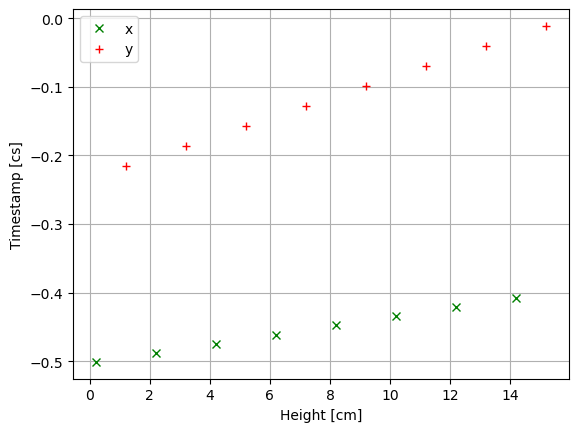

In [102]:
from track import Track
from time_correction import*
Hx=[]
Hy=[]
for number_hits in range(8):
    Hx.append(Hit([24,8-number_hits],1,0,1000,0.0))#(coord, is_sidex, timestamp, timestamp_event, value)
    Hy.append(Hit([number_hits+1,8-number_hits],0,0,1000,0.0))
Tx = Track(Hx)
Ty = Track(Hy)
T = Track3D(Tx,Ty)
T.show()

T_fiber_corrected = copy.deepcopy(T)
T_electronic_corrected = copy.deepcopy(T)
time_correction_fiber(T_fiber_corrected)
time_correction_electronics(T_electronic_corrected)

# recover the corrected stamps
heightsx = []
heightsy = []
s_nocorr = []
s_ecorr = []
s_fibcorr = []

for h in T_fiber_corrected.x.hits:# + T_fiber_corrected.y.hits:
    heightsx.append(h.get_pos()[1])
    s_fibcorr.append(h.timestamp)
for h in T_fiber_corrected.y.hits:# + T_fiber_corrected.y.hits:
    heightsy.append(h.get_pos()[1])
    s_nocorr.append(h.timestamp)

plt.figure()
plt.plot(heightsx,s_fibcorr,'gx')
plt.plot(heightsy,s_nocorr, 'r+')
plt.grid()
plt.xlabel("Height [cm]")
plt.ylabel("Timestamp [cs]")
plt.legend(["x","y"])
